<a href="https://colab.research.google.com/github/szh141/colab/blob/main/downsampling_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/19_spatial_transforms/downsampling_with_denoising.html


In [1]:
from skimage import data,transform
import numpy as np
from matplotlib import pyplot as plt

In [2]:
a1 = data.cells3d()
a1.shape

(60, 2, 256, 256)

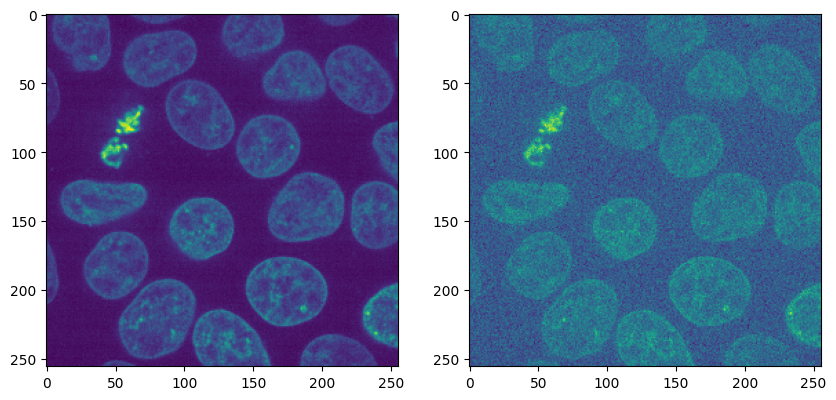

In [3]:
a2 = a1[30,1]
a2_noisy = a2 + np.random.normal(a2.mean(),a2.std(),a2.shape)
fig,ax = plt.subplots(1,2,figsize=(10,6))
ax[0].imshow(a2)
ax[1].imshow(a2_noisy)
plt.show()

In [ ]:
noise_area_a2 = a2[100:120,80:100]
noise_area_a2_noisy = a2_noisy[100:120,80:100]

def signal_2_noise(image1,noise_area):
  signal = np.percentile(image1,98) - noise_area.mean()
  noise = noise_area.std()
  return signal/noise

print(signal_2_noise(a2,noise_area_a2))
print(signal_2_noise(a2_noisy,noise_area_a2_noisy))

26.67732372080617
3.7438594226926876


Downsampling

::decimation_factor

The disadvantage of using numpy is that you are limited to decimation, limiting you to certain scaling factors (e.g. 1/2 = 0.5, 1/3 = 0.33333, 1/4 = 0.25, etc.).

if my xy vs z is 0.108333 vs 1um

scale_factor = 0.108333

decimation_factor = round(1 / scale_factor)

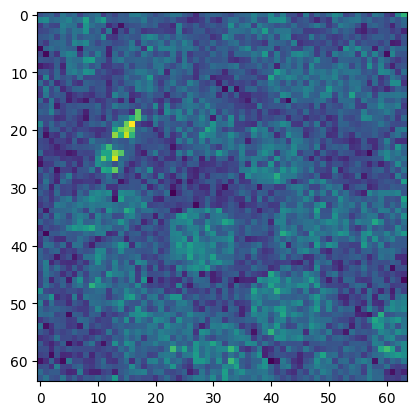

In [6]:
scale_factor = 0.25
#1:4 downsampling for example
decimation_factor = round(1 / scale_factor)
a2_decimated = a2_noisy[::decimation_factor, ::decimation_factor]
plt.imshow(a2_decimated)

Scikit-image rescale() without anti-aliasing

similar result to numpy decimated

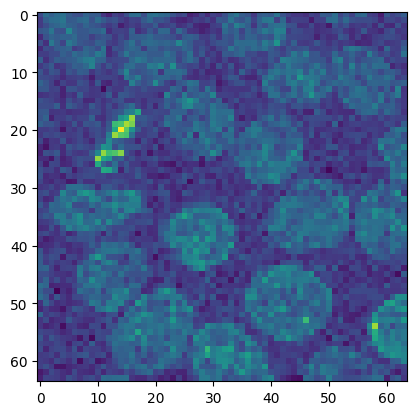

In [7]:
from skimage.transform import rescale
scikit_rescaled = rescale(a2_noisy, scale=scale_factor, anti_aliasing=False, preserve_range=True)
plt.imshow(scikit_rescaled)

Scikit-image rescale() with anti-aliasing

Below the hood, the ant-aliasing filter of scikit-image applies a gaussian filter, the sigma of which can be controlled by the `anti_aliasing_sigma` argument. Here we use a sigma that is 4 times smaller than the scale-factor to make sure that the image is not blurred more than necessary.

This looks a lot better than without anti-aliasing. The gaussian filter managed to remove the noise without loosing more detail than the down-sampling itself.

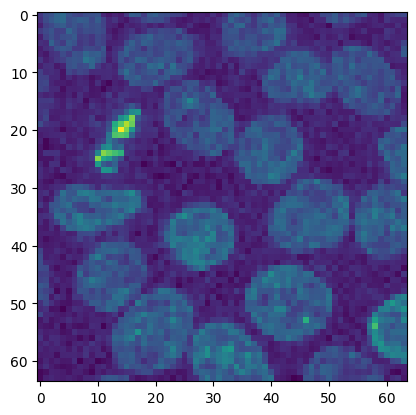

In [8]:
sigma = 1 / scale_factor / 4
scikit_rescaled_antialiasing = rescale(a2_noisy, scale=(scale_factor, scale_factor), anti_aliasing=True, anti_aliasing_sigma=sigma)
plt.imshow(scikit_rescaled_antialiasing)

Denoising with an average filter before down-scaling

Denoising with a gaussian filter is computationallyquite expensive, because it is applied to every pixel of the large original data. To alleviate this scikit-image provides the skimage.transform.downscale_local_mean() function (documentation) that averages over the decimation_factor x decimation_factor pixels before combining them into one pixel. This means that the denoising operation is only calculated as many times as there are output pixels. The disadvantage is, that this function requires integer decimation-factors, imposing the same limitations as the numpy decimation.

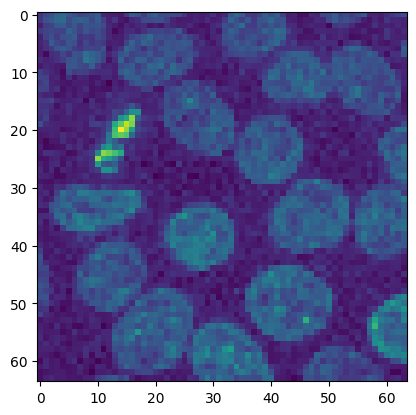

In [10]:
from skimage.transform import downscale_local_mean
scikit_downsampled = downscale_local_mean(a2_noisy, (decimation_factor, decimation_factor))
plt.imshow(scikit_downsampled)

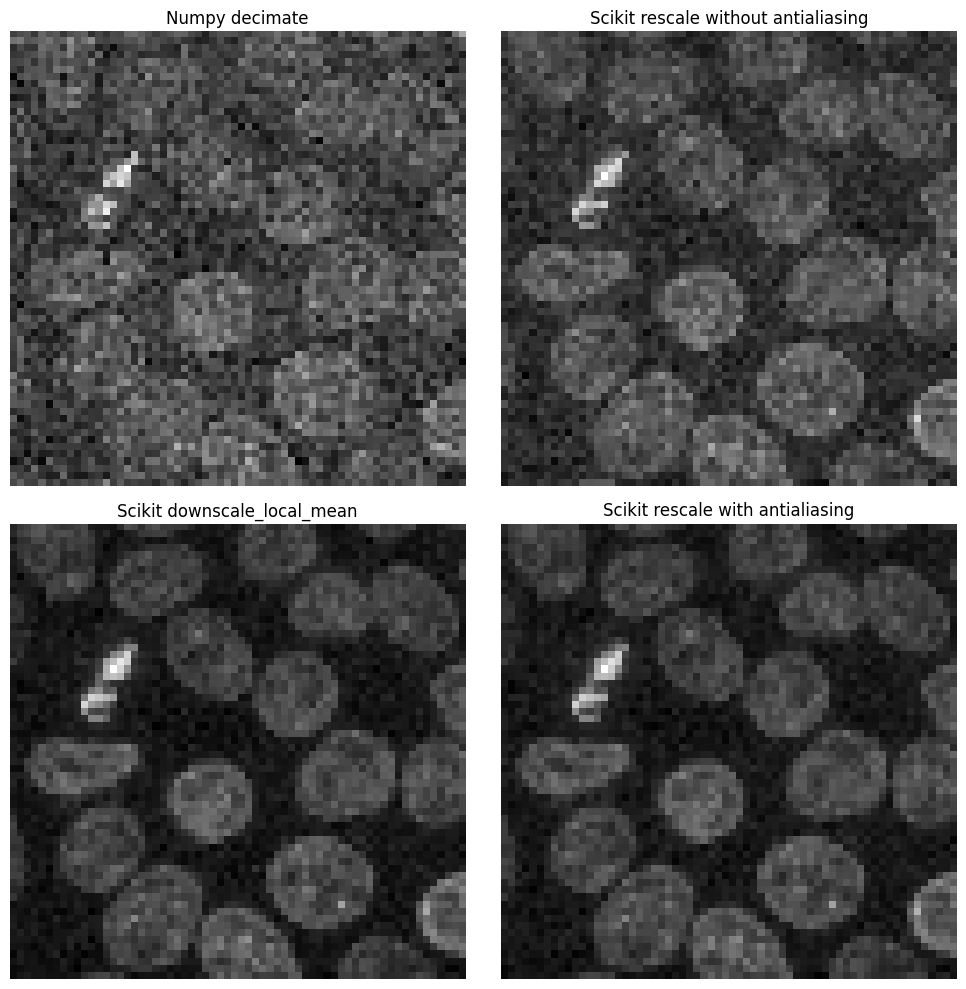

In [11]:
# Define the labels for figure titles and bar chart
labels = [
    'Numpy decimate',
    'Scikit rescale without antialiasing',
    'Scikit rescale with antialiasing',
    'Scikit downscale_local_mean',
]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(a2_decimated, cmap='gray')
axes[0, 0].set_title(labels[0])

axes[0, 1].imshow(scikit_rescaled, cmap='gray')
axes[0, 1].set_title(labels[1])

axes[1, 0].imshow(scikit_downsampled, cmap='gray')
axes[1, 0].set_title(labels[3])

axes[1, 1].imshow(scikit_rescaled_antialiasing, cmap='gray')
axes[1, 1].set_title(labels[2])


for ax in axes.flatten():
    ax.axis('off')

fig.tight_layout()
